# IA353 - Redes Neurais
# EFC3 - Questão 6 - Parte 2

## Predição de séries temporais empregando vários tipos de modelos
#### Parcialmente baseado em https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
## Caso de estudo: Série temporal estacionária e não-linear

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Rafael Ito

### 6.1. Importações e definições

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd
import math
import csv
import sklearn
import sklearn.preprocessing
import datetime
from pandas import DataFrame
from pandas import concat

# Specifi imports
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Steps")
    plt.ylabel("Time Series Values")
    plt.title("Sunspots Time Series")
    plt.grid(True)

Using TensorFlow backend.


### 6.2. Carregando a base de dados e apresentando sua composição

In [2]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

#series = np.loadtxt("C:/IA353/nlts.txt", dtype='f', delimiter=',')
!wget -nc -q https://raw.githubusercontent.com/ito-rafael/IA353A-NeuralNetworks-1s2020/master/EFC3/Q6/nlts.txt
series = np.loadtxt('/content/nlts.txt', dtype='f', delimiter=',')
series = series/15
series = series - np.mean(series)
print(series)

[-0.86525667 -0.9468028  -0.99788886 ... -0.12370616  0.30464625
 -0.1738807 ]


### 6.3. Exibindo o comportamento temporal de várias séries associadas à ação EQIX

Text(0, 0.5, 'Valor da série')

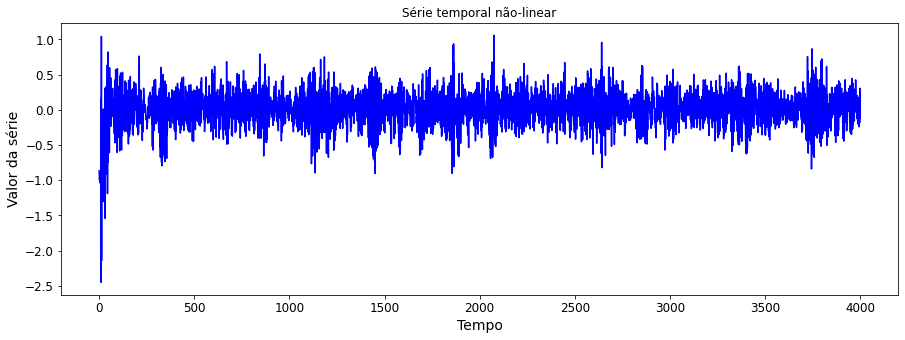

In [3]:
plt.figure(figsize=(15, 5));
plt.plot(series, color='blue', label='open')
plt.title('Série temporal não-linear')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')

### 6.4. Preparação da série temporal com linha de derivação de atraso, além de promover o particionamento entre conjuntos de treinamento, validação e teste

In [4]:
# function to create train, validation, test data given stock data and sequence length
def load_data(series, seq_len):
    data_raw = np.array(series) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
        
    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1]
    
    x_test = data[train_set_size+valid_set_size:,:-1]
    y_test = data[train_set_size+valid_set_size:,-1]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    y_train = y_train.reshape(-1,1)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    y_valid = y_valid.reshape(-1,1)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(-1,1)
    
    np.savetxt('Q6P2_x_train.txt', x_train)
    np.savetxt('Q6P2_y_train.txt', y_train)
    np.savetxt('Q6P2_x_valid.txt', x_valid)
    np.savetxt('Q6P2_y_valid.txt', y_valid)
    np.savetxt('Q6P2_x_test.txt', x_test)
    np.savetxt('Q6P2_y_test.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# create train, test data
seq_len = 10 # Número de atrasos a serem considerados
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(series, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3191, 10)
y_train.shape =  (3191, 1)
x_valid.shape =  (399, 10)
y_valid.shape =  (399, 1)
x_test.shape =  (399, 10)
y_test.shape =  (399, 1)


### 6.5. Visualização do comportamento da série temporal de teste

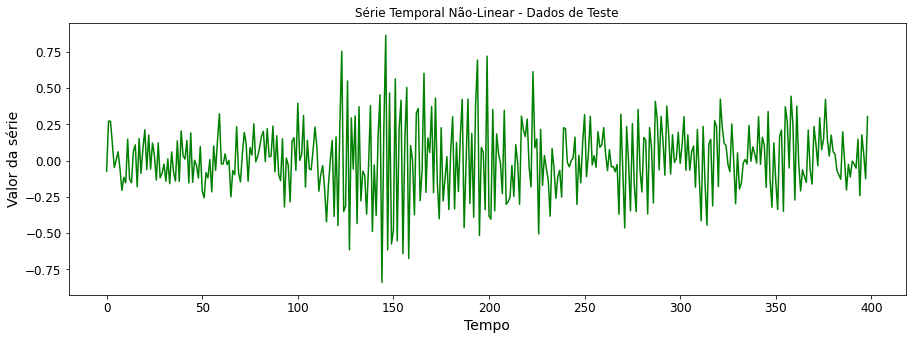

In [5]:
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='green')
plt.title('Série Temporal Não-Linear - Dados de Teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.show()

### 6.6. Sintetizando um preditor linear

In [6]:
from sklearn.linear_model import LinearRegression

nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
lr = LinearRegression()
lr.fit(X, y_train)
w = lr.coef_[0]
print('Coeficientes do preditor linear')
print(w)

Coeficientes do preditor linear
[ 0.27299142  0.03401006 -0.18766307 -0.33875786  0.05451361  0.15593558
  0.22825877  0.44130719  0.05621329 -0.2540271   0.        ]


#### 6.6.1. Visualização do desempenho do preditor linear

In [7]:
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor Linear')
nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
y_pred = X.dot(w)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Linear')
nr,nc = x_valid.shape
B = np.ones((nr,1))
X = np.hstack((x_valid,B))
y_pred = X.dot(w)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Linear')
nr,nc = x_test.shape
B = np.ones((nr,1))
X = np.hstack((x_test,B))
y_pred = X.dot(w)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Linear
0.043909087273997685
EQM final de validação após o término do treinamento - Preditor Linear
0.031301683631628635
EQM final de teste após o término do treinamento - Preditor Linear
0.04225981520778723


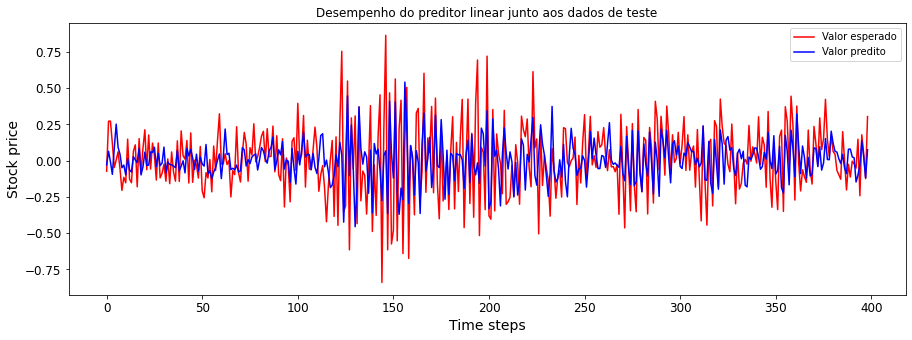

In [8]:
y_pred = X.dot(w)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor linear junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.7. Sintetizando um preditor não-linear MLP

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [10]:
EPOCHS = 100
np.random.seed(42)
tf.random.set_seed(42)

model_MLP = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.tanh),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    keras.layers.Dense(1)
])

model_MLP.compile(loss="mse", optimizer="adam")

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_MLP_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_MLP.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        validation_data=(x_valid, y_valid), 
                        callbacks=[earlystop, best_val], 
                        verbose=1)

Epoch 1/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0520 - val_loss: 0.0324
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0402
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0368
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0310
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0305
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0336
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0311
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0330
Epoch 9/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0326
Epoch 10/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0418 - val_lo

In [11]:
model_MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1408      
_________________________________________________________________
dense_1 (Dense)              multiple                  8256      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


#### 6.7.1. Carregando o modelo com o menor MAPE para o preditor MLP

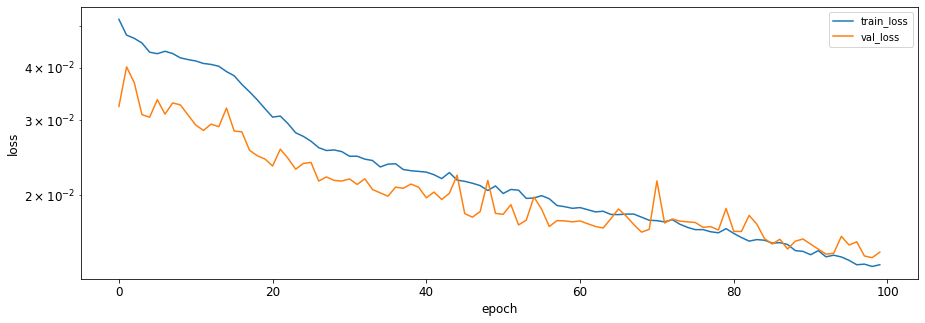

In [12]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_MLP.load_weights("model_MLP_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.7.2. Visualização do desempenho do preditor MLP

In [13]:
#weights = model_MLP.get_weights()
#print(weights)
print('EQM final de treinamento após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor MLP
0.012596775
EQM final de validação após o término do treinamento - Preditor MLP
0.014233265
EQM final de teste após o término do treinamento - Preditor MLP
0.018728197


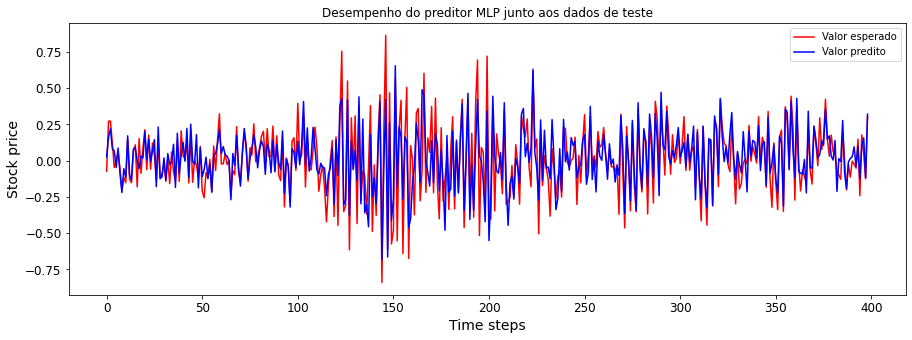

In [14]:
y_pred = model_MLP.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor MLP junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.8. Sintetizando um preditor não-linear Simple RNN

In [15]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN1 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model_RNN1.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN1_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN1.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(3191, 10, 1)
(3191, 1)
(399, 10, 1)
(399, 1)
(399, 10, 1)
(399, 1)
Epoch 1/100
100/100 [==============================] - 2s 16ms/step - loss: 0.0622 - val_loss: 0.0316
Epoch 2/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0455 - val_loss: 0.0315
Epoch 3/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0440 - val_loss: 0.0289
Epoch 4/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0429 - val_loss: 0.0282
Epoch 5/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0396 - val_loss: 0.0272
Epoch 6/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0385 - val_loss: 0.0271
Epoch 7/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0373 - val_loss: 0.0255
Epoch 8/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0358 - val_loss: 0.0244
Epoch 9/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0344 - val_loss: 0.0243
Epoch 10/100
1

In [16]:
model_RNN1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


#### 6.8.1. Carregando o modelo com o menor MAPE para o preditor não-linear Simple RNN

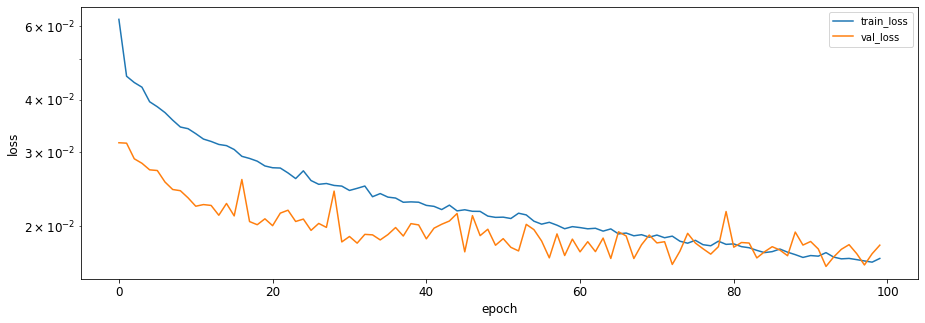

In [17]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN1.load_weights("model_RNN1_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.8.2. Visualização do desempenho do preditor não-linear Simple RNN junto aos dados de teste

In [18]:
print('EQM final de treinamento após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Simple RNN
0.016017552
EQM final de validação após o término do treinamento - Preditor Simple RNN
0.016005328
EQM final de teste após o término do treinamento - Preditor Simple RNN
0.020163465


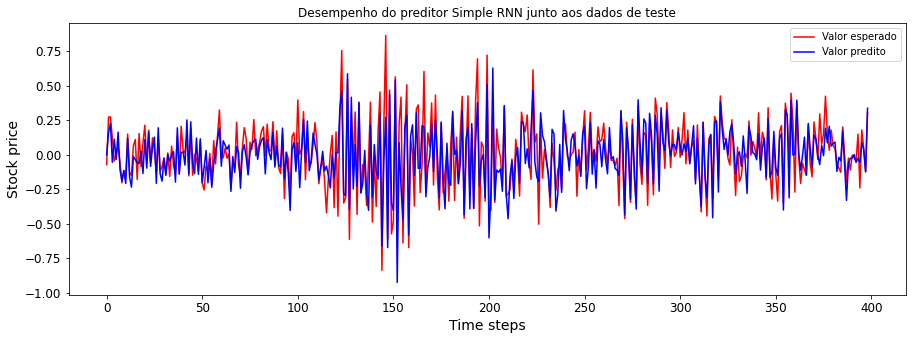

In [19]:
y_pred = model_RNN1.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor Simple RNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.9. Sintetizando um preditor não-linear com bloco LSTM GRU

In [20]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN2 = keras.models.Sequential([
    keras.layers.GRU(seq_len, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(seq_len, return_sequences=True),
    keras.layers.Dense(1)
])

model_RNN2.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN2_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN2.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(3191, 10, 1)
(3191, 1)
(399, 10, 1)
(399, 1)
(399, 10, 1)
(399, 1)
Epoch 1/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0636 - val_loss: 0.0532
Epoch 2/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0632 - val_loss: 0.0536
Epoch 3/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0632 - val_loss: 0.0530
Epoch 4/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0630 - val_loss: 0.0530
Epoch 5/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0628 - val_loss: 0.0528
Epoch 6/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0629 - val_loss: 0.0536
Epoch 7/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0628 - val_loss: 0.0529
Epoch 8/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0626 - val_loss: 0.0528
Epoch 9/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0624 - val_loss: 0.0533
Epoch 10/100
100/100 [

In [21]:
model_RNN2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 10)          390       
_________________________________________________________________
gru_1 (GRU)                  (None, None, 10)          660       
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           11        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
_________________________________________________________________


#### 6.9.1. Carregando o modelo com o menor MAPE para o preditor não-linear com bloco LSTM GRU

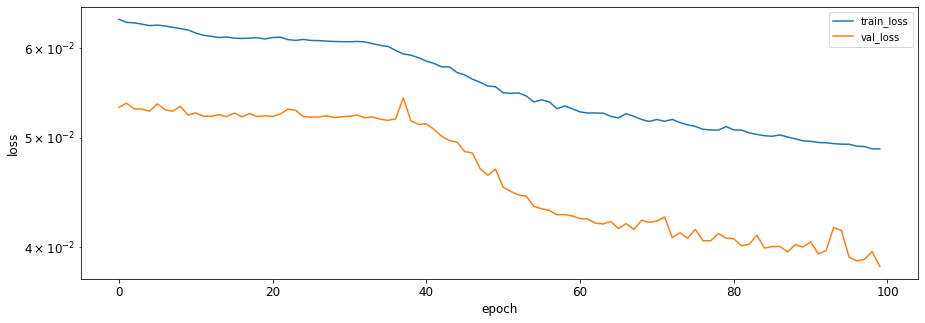

In [22]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN2.load_weights("model_RNN2_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.9.2. Visualização do desempenho do preditor não-linear com bloco LSTM GRU junto aos dados de teste

In [23]:
print('EQM final de treinamento após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_train,y_train)
print('EQM final de validação após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_valid,y_valid)
print('EQM final de teste após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_test,y_test)

EQM final de treinamento após o término do treinamento - Preditor LSTM GRU
100/100 [==============================] - 0s 3ms/step - loss: 0.0484
EQM final de validação após o término do treinamento - Preditor LSTM GRU
13/13 [==============================] - 0s 2ms/step - loss: 0.0385
EQM final de teste após o término do treinamento - Preditor LSTM GRU
13/13 [==============================] - 0s 3ms/step - loss: 0.0484


0.04836990311741829

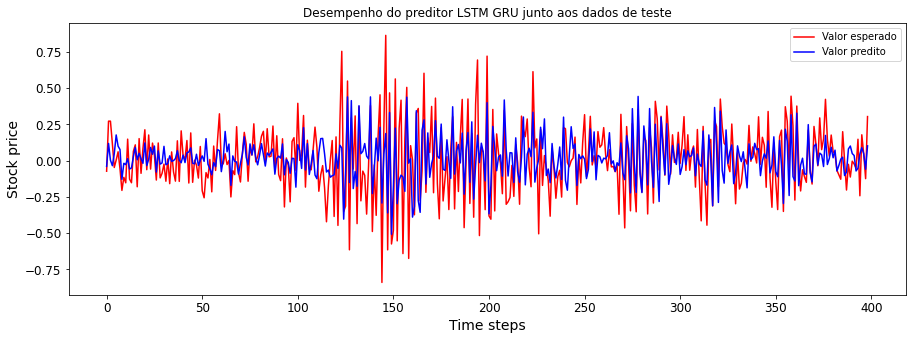

In [24]:
y_pred = model_RNN2.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred[:,seq_len-1], color='blue', label='Valor predito')
plt.title('Desempenho do preditor LSTM GRU junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.10. Sintetizando um preditor não-linear CNN 1D
#### Parcialmente baseado em https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/1_CNN_dilated.ipynb

In [25]:
from keras.layers import Conv1D, Dense, Flatten
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
model_CNN = Sequential()
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(seq_len, 1)))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model_CNN.add(Flatten())
model_CNN.add(Dense(1, activation='linear'))
model_CNN.compile(optimizer='Adam', loss='mse')

In [26]:
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 5)             15        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


In [27]:
from keras.callbacks import ModelCheckpoint

In [28]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_CNN_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_CNN.fit(x_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Train on 3191 samples, validate on 399 samples
Epoch 1/100
3191/3191 [==============================] - 1s 243us/step - loss: 0.0633 - val_loss: 0.0414
Epoch 2/100
3191/3191 [==============================] - 0s 119us/step - loss: 0.0526 - val_loss: 0.0330
Epoch 3/100
3191/3191 [==============================] - 0s 112us/step - loss: 0.0471 - val_loss: 0.0309
Epoch 4/100
3191/3191 [==============================] - 0s 106us/step - loss: 0.0431 - val_loss: 0.0283
Epoch 5/100
3191/3191 [==============================] - 0s 103us/step - loss: 0.0405 - val_loss: 0.0267
Epoch 6/100
3191/3191 [==============================] - 0s 108us/step - loss: 0.0390 - val_loss: 0.0264
Epoch 7/100
3191/3191 [==============================] - 0s 108us/step - loss: 0.0379 - val_loss: 0.0258
Epoch 8/100
3191/3191 [==============================] - 0s 109us/step - loss: 0.0369 - val_loss: 0.0259
Epoch 9/100
3191/3191 [==============================] - 0s 107us/step - loss: 0.0363 - val_loss: 0.0249
Epoch 10

#### 6.10.1. Carregando o modelo com o menor MAPE para o preditor CNN

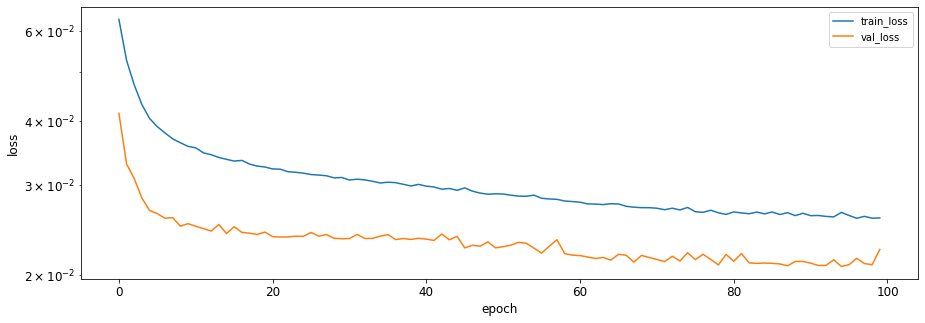

In [29]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_CNN.load_weights("model_CNN_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.10.2. Visualização do desempenho do preditor CNN junto aos dados de teste

In [30]:
print('EQM final de treinamento após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor CNN
0.025608016
EQM final de validação após o término do treinamento - Preditor CNN
0.0207754
EQM final de teste após o término do treinamento - Preditor CNN
0.02545591


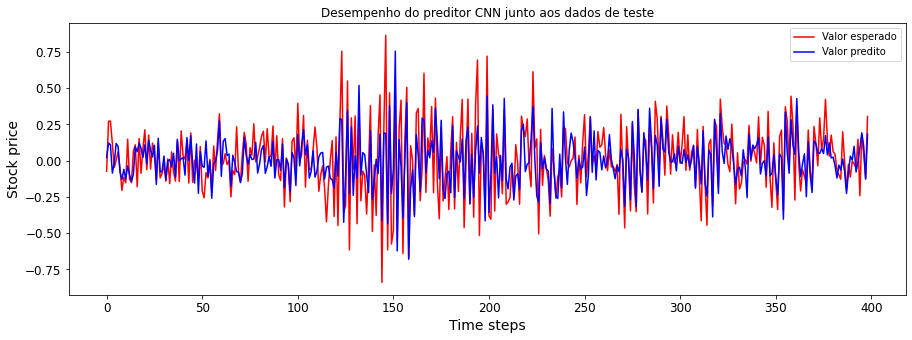

In [31]:
y_pred = model_CNN.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor CNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

## Atividades práticas

### 6.2.1. Resumo geral


Atividade:  
Forneça o notebook devidamente executado, contendo, ao final, um resumo geral do que foi trabalhado em cada seção. Forneça, por exemplo, o número de atrasos da série temporal que está sendo considerado como entrada dos preditores e como está sendo feita a regularização dos modelos, quando for o caso.

Resposta:  
Forneça, por exemplo, o número de atrasos da série temporal que está sendo considerado como entrada dos preditores e como está sendo feita a regularização dos modelos, quando for o caso.

Resposta:  
- 6.1: 
  - Importação de módulos

- 6.2: 
  - Carregamento dos dados sintéticos NLTS (Non-Linear Time Series)

- 6.3: 
  - Visualização dos dados da série temporal

- 6.4:
  - Partição dos dados em treino, validação e teste
  - Função para formação dos dados de treino, validação e teste dado o tamanho da sequência desejada, seq_len (número de dias anteriores à predição), definido aqui com o valor 10

- 6.5:
  - Gráfico com os valores dos dados de conjunto de teste

- 6.6:
  - Sintetização de um preditor linear usando a classe LinearRegression da biblioteca scikit-learn
  - Impressão dos valores dos pesos do preditor linear
  - Cálculo do EQM de treinamento, validação e teste após o fim do treinamento
  - Plot dos valores esperados e preditos considerando o conjunto de teste

- 6.7
  - Sintetização de um preditor não-linear usando uma rede MLP de 4 camadas densas
    - camadas: entrada, 128 neurônios, 64 neurônios e 1 neurônio (saída)
    - treinamento: 100 épocas, otimizador Adam, loss MSE
    - número de atrasos da série temporal que está sendo considerado como entrada dos preditores: 10
  - Resumo do modelo mostrando camadas e número de parâmetros
  - Plot da loss de treino e validação ao longo das épocas
  - Cálculo do EQM de treinamento, validação e teste após o fim do treinamento
  - Plot dos valores esperados e preditos considerando o conjunto de teste

- 6.8:
  - Sintetização de um preditor não-linear usando uma rede neural recorrente
    - camadas: duas camadas SimpleRNN (com 20 neurônios) e uma camada densa de saída
    - treinamento: 100 épocas, otimizador Adam, loss MSE
    - número de atrasos da série temporal que está sendo considerado como entrada dos preditores: 10
  - Resumo do modelo mostrando camadas e número de parâmetros
  - Plot da loss de treino e validação ao longo das épocas
  - Cálculo do EQM de treinamento, validação e teste após o fim do treinamento
  - Plot dos valores esperados e preditos considerando o conjunto de teste

- 6.9:
  - Sintetização de um preditor não-linear usando o bloco GRU (semelhante ao bloco LSTM)
    - camadas: duas camadas GRU (10 unidades) e uma camada densa de saída
    - treinamento: 100 épocas, otimizador Adam, loss MSE
    - número de atrasos da série temporal que está sendo considerado como entrada dos preditores: 10
  - Resumo do modelo mostrando camadas e número de parâmetros
  - Plot da loss de treino e validação ao longo das épocas
  - Cálculo do EQM de treinamento, validação e teste após o fim do treinamento
  - Plot dos valores esperados e preditos considerando o conjunto de teste

- 6.10:
  - Sintetização de um preditor não-linear usando camadas convolucionais
    - camadas: três camadas convolucionais Conv1D (kernel 2, relu, stride=1) e uma camada densa de saída
    - treinamento: 100 épocas, otimizador Adam, loss MSE
    - número de atrasos da série temporal que está sendo considerado como entrada dos preditores: 10
  - Resumo do modelo mostrando camadas e número de parâmetros
  - Plot da loss de treino e validação ao longo das épocas
  - Cálculo do EQM de treinamento, validação e teste após o fim do treinamento
  - Plot dos valores esperados e preditos considerando o conjunto de teste

### 6.1.2. Preditor linear

Atividade: Dadas as características da série temporal, explique o motivo pelo qual o preditor linear saiu de primeiro colocado em desempenho, na Parte 1, para último colocado nesta Parte 2. 

Resposta:  
Na parte 1 tínhamos uma série impossível de se prever conhecendo apenas valores passados (ou então pessoas com conhecimentos de machine learning estaria todas ricas!). Como se tratava de uma série temporal de valores da bolsa de Nova York, o modelo mais conservador, que era o modelo linear, fazia uma predição tomando como base o valor imediatamente anterior a predição (peso de mais relevância). Como o próximo valor pode tanto crescer como decrescer, na média, o preditor linear se mostrou muito eficiente, pois erra menos. Já neste caso da parte 2, temos uma série temporal que apresenta comportamento não-linear e estacionário. Assim, deixamos o aleatório de lado e realmente podemos captar dependências de valores passados e relacioná-los com valores futuros a serem preditos. Desta forma, o preditor linear, que como o próprio nome diz é incapaz de apresentar características não-lineares, se torna bastante ineficiente para este caso.

### 6.1.3. Preditor de múltiplos passos à frente

Atividade: Escolha um dos preditores e implemente a predição de múltiplos passos à frente (several time steps ahead), explicando como funciona a sua metodologia. 

Resposta:
Existem várias formas de implementar um preditor de múltiplos passos à frente. Dois dos principais métodos são listados a seguir:
- Estratégia de predição de vários passos direta:  
  - Neste caso, se quisermos prever "p" passos à frente, considerando os "l" valores passados como entradas e tendo "N" dados, temos:  
$X = [s_1, s_2, ..., s_l]; y = [s_{l+p}]$  
...   
$X = [s_{N-p-l}, s_{N-p-l+1}, ..., s_{N-p}]; y = [s_N]$  
  - Também é possível usar múltiplas saídas, prevendo portanto todos os próximos passos até "p".  
A vantagem dessa estratégia é conseguir inferir o valor de "p" passos à frente de uma vez (consultar a próxima estratégia). A desvantagem é não captar as dependências entre as predições, pois a predição de "p" passos à frente, comumente apresenta dependências com a predição de "p-1" passos à frente.

- Predição de vários passos de forma recursiva:  
Neste caso, usamos um preditor semelhante ao que foi fornecido pelo professor. A diferença está no fato de usar predições como entradas para o cálculo de passos à frente. Assim, se quisermos um preditor de 5 passos à frente considerando 10 entradas passadas, por exemplo, faríamos a predição de 1 passo a frente a partir de 10 dados reais, em seguida usaríamos 9 dados reais e a predição anterior para calcular 2 passos à frente, até usar 6 dados reais e 4 predições para calcular 5 passos à frente.  
A vantagem deste modelo está em captar as dependências das predições. Por outro lado, quanto mais a frente for a predição, maior o erro acumulado e portanto menor será a performance.

Para esta atividade, implementaremos o caso da estratégia direta considerando uma única saída "p" passos à frente (e portanto um preditor apenas, ao invés de "p" preditores, sendo que a extensão para múltiplas saídas nada mais é do que "p" preditores sintetizados de forma semelhante a este).

In [32]:
# function to create train, validation, test data given stock data and sequence length
def load_data_steps(series, seq_len, steps=1):
    data_raw = np.array(series) # convert to numpy array
    data = []
    output = np.roll(series, 1-steps-seq_len)
    output = np.delete(output, np.s_[(-steps-seq_len-1):])
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - steps - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
        
    x_train = data[:train_set_size,:-1]
    #y_train = data[:train_set_size,-1]
    y_train = output[:train_set_size]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1]
    #y_valid = data[train_set_size:train_set_size+valid_set_size,-1]
    y_valid = output[train_set_size:train_set_size+valid_set_size]
    
    x_test = data[train_set_size+valid_set_size:,:-1]
    #y_test = data[train_set_size+valid_set_size:,-1]
    y_test = output[train_set_size+valid_set_size:]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    y_train = y_train.reshape(-1,1)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    y_valid = y_valid.reshape(-1,1)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(-1,1)
    
    # stsa: several time steps ahead
    np.savetxt('Q6P2_stsa_x_train.txt', x_train)
    np.savetxt('Q6P2_stsa_y_train.txt', y_train)
    np.savetxt('Q6P2_stsa_x_valid.txt', x_valid)
    np.savetxt('Q6P2_stsa_y_valid.txt', y_valid)
    np.savetxt('Q6P2_stsa_x_test.txt', x_test)
    np.savetxt('Q6P2_stsa_y_test.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# create train, test data
seq_len = 10 # Número de atrasos a serem considerados
steps=3
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data_steps(series, seq_len, steps=steps)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3188, 10)
y_train.shape =  (3188, 1)
x_valid.shape =  (399, 10)
y_valid.shape =  (399, 1)
x_test.shape =  (399, 10)
y_test.shape =  (399, 1)


In [33]:
print(x_train[0])
print(y_train[0])
print(series[:(seq_len+steps)])

[-0.86525667 -0.9468028  -0.99788886 -0.96390605 -0.95436054 -1.0392921
 -1.0173609  -0.8988174  -0.9328047  -0.9797272 ]
[1.0421048]
[-0.86525667 -0.9468028  -0.99788886 -0.96390605 -0.95436054 -1.0392921
 -1.0173609  -0.8988174  -0.9328047  -0.9797272   0.15599978 -2.4517884
  1.0421048 ]


#### Visualização do comportamento da série temporal de teste

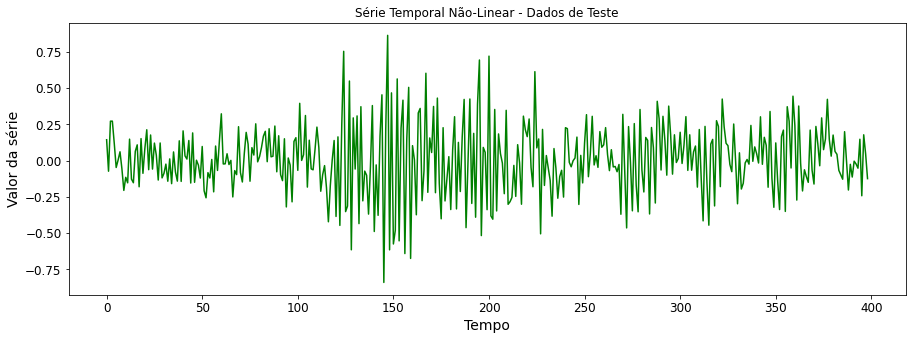

In [34]:
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='green')
plt.title('Série Temporal Não-Linear - Dados de Teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.show()

Se compararmos com a visualização dos dados de teste da seção 6.4, podemos ver que a curva é a mesma, mas deslocada de "steps" para a esquerda e com o final truncado por causa da construção dos dados.

#### Sintetizando um preditor não-linear MLP

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [36]:
EPOCHS = 300
PATIENCE = 20
np.random.seed(42)
tf.random.set_seed(42)

model_MLP = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation=tf.nn.tanh),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation=tf.nn.tanh),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation=tf.nn.tanh),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    keras.layers.Dense(1)
])

model_MLP.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_MLP_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_MLP.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        validation_data=(x_valid, y_valid), 
                        callbacks=[earlystop, best_val], 
                        verbose=1)

Epoch 1/300
100/100 [==============================] - 0s 4ms/step - loss: 0.1484 - val_loss: 0.0338
Epoch 2/300
100/100 [==============================] - 0s 3ms/step - loss: 0.1065 - val_loss: 0.0326
Epoch 3/300
100/100 [==============================] - 0s 3ms/step - loss: 0.0861 - val_loss: 0.0321
Epoch 4/300
100/100 [==============================] - 0s 3ms/step - loss: 0.0742 - val_loss: 0.0324
Epoch 5/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0697 - val_loss: 0.0328
Epoch 6/300
100/100 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.0323
Epoch 7/300
100/100 [==============================] - 0s 3ms/step - loss: 0.0606 - val_loss: 0.0325
Epoch 8/300
100/100 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0324
Epoch 9/300
100/100 [==============================] - 0s 3ms/step - loss: 0.0567 - val_loss: 0.0325
Epoch 10/300
100/100 [==============================] - 0s 3ms/step - loss: 0.0557 - val_lo

In [37]:
model_MLP.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  2816      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  65792     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_7 (Dense)              multiple                  32896     
_________________________________________________________________
dropout_2 (Dropout)          multiple                 

#### Carregando o modelo com o menor MAPE para o preditor MLP

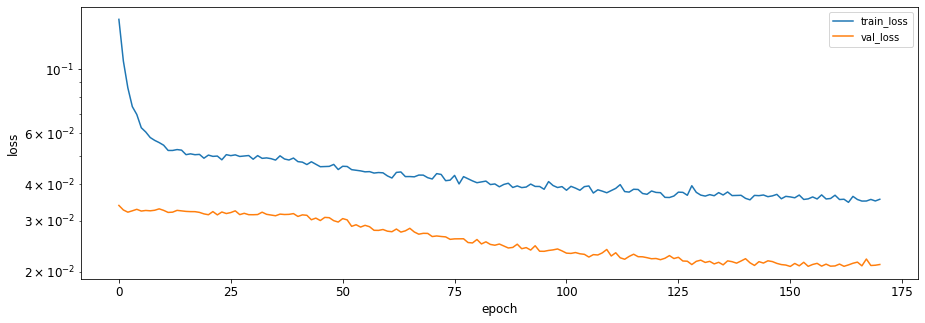

In [38]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_MLP.load_weights("model_MLP_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### Visualização do desempenho do preditor MLP

In [39]:
#weights = model_MLP.get_weights()
#print(weights)
print('EQM final de treinamento após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor MLP
0.028435217
EQM final de validação após o término do treinamento - Preditor MLP
0.020825608
EQM final de teste após o término do treinamento - Preditor MLP
0.029160071


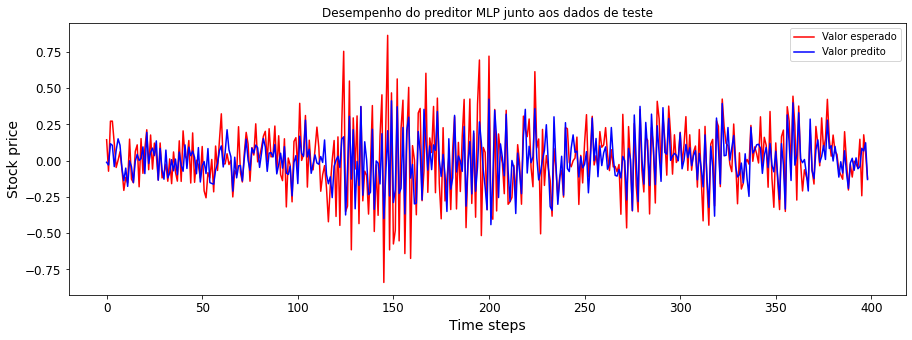

In [40]:
y_pred = model_MLP.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor MLP junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.1.4. Metodologia em série temporal não-estacionária

Atividade: Sem a necessidade de implementações práticas, explique que modificações metodológicas você faria caso se constatasse que a série temporal é não-estacionária, mas com uma variação lenta de suas propriedades estatísticas ao longo do tempo.


Rsposta:  
Caso a série seja não-estacionária, mas apresente variação lenta, um possível workaround seria trabalhar com o conceito de média móvel. Assim, seria possível fazer ajustes considerando o longo prazo (ou variações de baixa frequência) para compensar o fato de a série ser não-estacionária. Outra possibilidade é trabalhar com modelos naturalmente lidam com este tipo de problema, como modelos da classe ARIMA. 

# End of Notebook